In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split

from logistic_regression import LogisticRegressionGD
from extrapolation import *
from experiments import RestartingExperiment

In [3]:
device = "cpu"

X = []
with open("../../../madelon_train.data") as f:
    for line in f:
        X.append([float(x) for x in line.split()])
X = np.array(X)
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
X = torch.tensor(X, device=device)
with open("../../../madelon_train.labels") as f:
    y = [int(x) for x in f]
y = torch.tensor(y, device=device)
X.shape, y.shape

(torch.Size([2000, 501]), torch.Size([2000]))

In [4]:
np.random.seed(2020)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

$\tau = 10^2$

In [5]:
model = LogisticRegressionGD(X_train, y_train, 1e2, device=device)

In [6]:
model.run_steps(50500)

In [7]:
len(model.log)

50501

In [8]:
preds = model.predict(X_test)
torch.mean((preds == y_test).double())

tensor(0.5750, dtype=torch.float64)

In [12]:
experiment = RestartingExperiment(model, device="cpu")

In [13]:
experiment.run_method("RRE+QR", RRE, 5, 10000, method_kwargs={"qr": True})

In [14]:
experiment.run_method("TEA", TEA, 10, 10000, input_size=5)

In [15]:
experiment.run_method("RRE+QR", RRE, 5, 10000, method_kwargs={"qr": True})

In [16]:
experiment.run_method("RNA+norm", RNA, 5, 10000, method_kwargs={"lambda_range": (1e-15, 1e-2), "linesearch": False})

In [17]:
experiment.run_method("RNA+ls", RNA, 5, 10000, method_kwargs={"lambda_range": (1e-15, 1e-2), "linesearch": True})

In [18]:
experiment.run_method("Epsilon inv", vector_epsilon_v1, 10, 10000, method_kwargs={"k": 5})

In [19]:
experiment.run_method("Epsilon mult", vector_epsilon_v2, 10, 10000, method_kwargs={"k": 5})

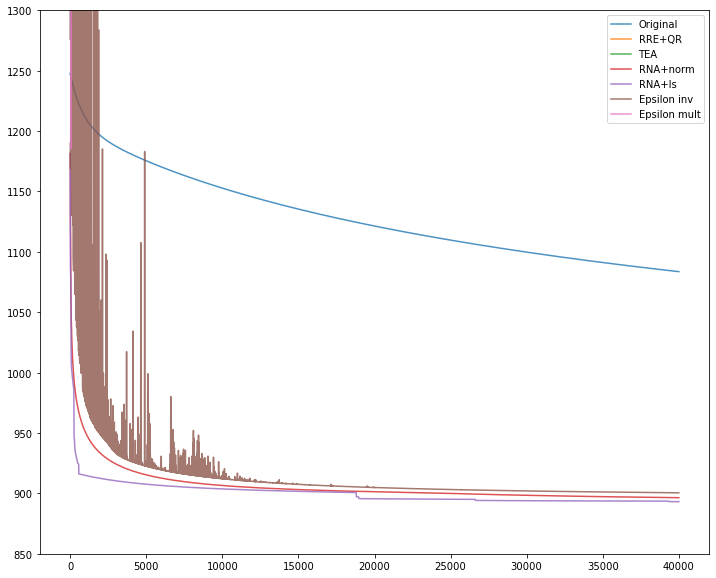

In [20]:
experiment.plot_values(n=40000, figsize=(12, 10), ylim=(850, 1300))

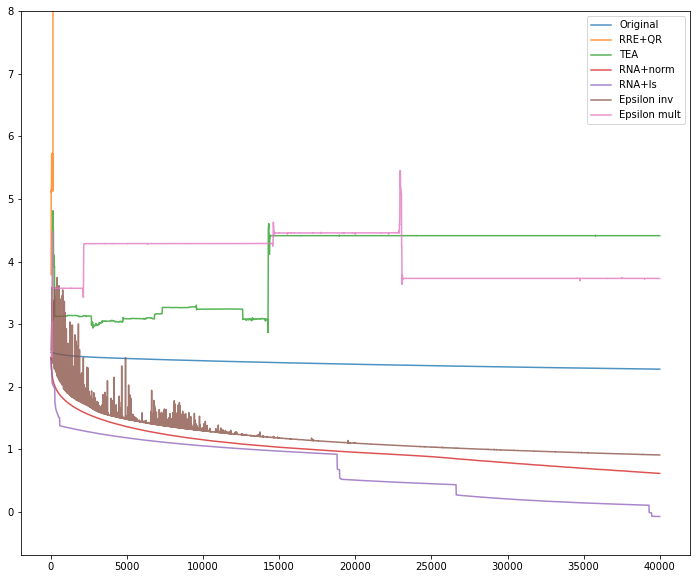

In [25]:
experiment.plot_log_diff(n=40000, figsize=(12, 10), ylim=(None, 8))

In [ ]:
experiment.save("madelon-restarts-1e2.p")